## Важно:

Пожалуйста, поддерживайте ваш код в хорошем состоянии, пишите комментарии, убирайте бесполезные ячейки, пишите модели в специально отведенных модулях. Проверяющие могут **НА СВОЕ УСМОТРЕНИЕ** снижать баллы за:

1. Говнокод
2. Неэффективные решения
3. Вермишель из ячеек в тетрадке
4. Все остальное что им не понравилось

## Важно 2 (0 - 0.3 балла):

За использование логгеров типа wandb/comet/neptune и красивую сборку этой домашки в виде графиков/картинок в этих логгерах мы будем выдавать бонусные баллы. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import neptune

neptune.init(
    project_qualified_name='penchekrak/ysda-spring2021-gans-hw1',
    api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vdWkubmVwdHVuZS5haSIsImFwaV91cmwiOiJodHRwczovL3VpLm5lcHR1bmUuYWkiLCJhcGlfa2V5IjoiZjZkODM3ZjMtYTY4Yy00ZjQ0LThmNTUtNGE0ZTY2M2E0N2RhIn0='
)

Project(penchekrak/ysda-spring2021-gans-hw1)

## Важно 3:

Решением домашки является архив с использованными тетрадками/модулями, а так же **.pdf файл** с отчетом по проделанной работе по каждому пункту задачи. В нем необходимо описать какие эксперименты вы производили чтобы получить результат который вы получили, а так же обосновать почему вы решили использовать модели которые вы использовали (например denoising AE или sparce AE в пункте 1)




In [3]:
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
from tqdm.notebook import tqdm


import matplotlib.pyplot as plt
%matplotlib inline

В этом домашнем задании мы будем автоэнкодить Omniglot. Omniglot - это датасет в основном для few-shot learning'а, состоящий из рукописных символов из разных существующих и несуществующих (эльфийский, клингонский) языков.

В этом датасете очень много классов, для для каждого класса представлено только 10-20 картинок. Если учить честную классификацию, мы быстро столкнемся с тем, что модель не сможет нормально выучиться.

В этой тетрадке вам предлагается попробовать решить эту проблему - выучить автоэнкодер (любой формы) и, используя латентное его представление, делать классификацию более сложными методами на меньше размерности.

Omniglot очень странно построен, в нем background - это единицы, а не нули. Чтобы перевести это в удобный для нас формат - инвертируем каждый пиксель через нашу кастомную трансформацию - InvertImage


In [8]:
class InvertImage:
    def __call__(self, pic):
        return 1 - pic

    def __repr__(self):
        return self.__class__.__name__ + '()'


In [9]:
from omniglot import FullOmniglot
from torchvision import transforms

from torch.utils.data import DataLoader, Subset

from sklearn.model_selection import train_test_split

data_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    InvertImage(),
#     transforms.Normalize([0.5], [0.5])
])

cuda_num = 1
device = f'cuda:{cuda_num}' if torch.cuda.is_available() else 'cpu'
batch_size = 64


Мы используем кастомный датасет FullOmniglot потому что изначально train/val части омниглота использую разные классы. Мы обьединяем их и делаем свое разбиение

In [19]:
full_dataset = FullOmniglot('./Omniglot', transform=data_transforms, download=True)

labels = []
for _, label in full_dataset:
    labels.append(label)
    
# делаем так, чтобы сплит был сбалансированным по классам
indices_train, indices_test, _, _ = train_test_split(list(range(len(labels))), labels, test_size=0.1, stratify=labels)

train_dataset = Subset(full_dataset, indices=indices_train)
test_dataset = Subset(full_dataset, indices=indices_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, drop_last=True)


Files already downloaded and verified
Files already downloaded and verified


In [20]:
def process_image(image):
    return (image.squeeze().detach().to('cpu') + 1) / 2

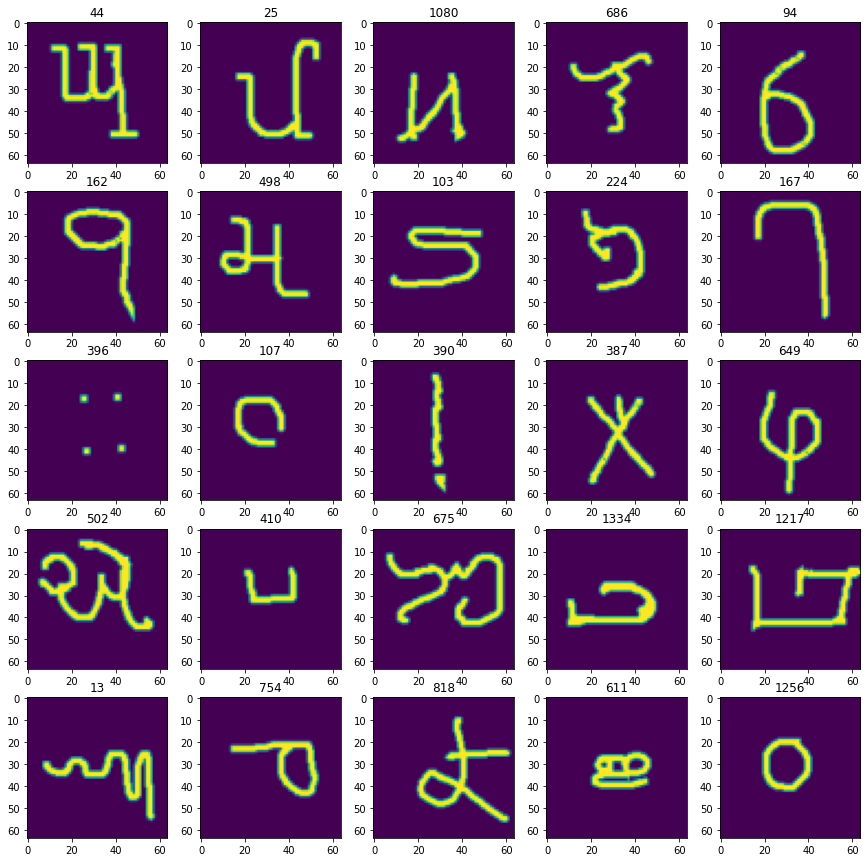

In [8]:
test_batch = next(iter(train_loader))


plt.figure(figsize=(15, 15))
for ind, (image, label) in enumerate(zip(*test_batch)):
    if ind >= 25: break
    plt.subplot(5, 5, ind+1)
    plt.imshow(process_image(image))
    plt.title(label.item())
plt.show()
    

### Задача 1 (0.3 балла):

Написать свой автоэнкодер, доучить его до приличного качества

Для того чтобы писать красивый код и не делать тетрадку слишком длинной предлагается писать свои модели в отдельном модуле, см `./autoencoder.py`

Классический трейнлуп: Описан в train.py

Note: я буду уважать вас сильнее если вместо вывода графика в тетрадку вы будете логгировать все (лоссы + картинки) в wandb/comet/neptune. И так далее по ходу тетрадки тоже

In [45]:
from losses import Image2ImageMSELoss, Image2ImageBCELoss, Image2ImageMixedLoss, Image2ImageMixedLossWithLasso
from train import Trainer
from callbacks import (
    NeptuneValidationBatchEnd,
    NeptuneOnFitEnd,
    NeptuneOnFitStart,
    NeptuneOnTrainingBatchEnd,
    SampleFromModelOnFitEnd,
    PlotLossesOnFitEnd,
    DisplayReconstructionOnFitEnd,
    ClfAccuracyOnFitEnd
)
callbacks = dict(
    on_fit_start=[NeptuneOnFitStart(name='autoencoder experiment')],
    on_training_batch_end=[NeptuneOnTrainingBatchEnd()],
    on_validation_batch_end=[NeptuneValidationBatchEnd()],
    on_fit_end=[PlotLossesOnFitEnd(), DisplayReconstructionOnFitEnd(), SampleFromModelOnFitEnd(), NeptuneOnFitEnd()], 
)

In [9]:
from autoencoder import DefaultAutoEncoder

ae = DefaultAutoEncoder()
optim = torch.optim.Adam(ae.parameters(), lr=0.001)
criterion = Image2ImageMSELoss()

https://ui.neptune.ai/penchekrak/ysda-spring2021-gans-hw1/e/YSDAGANHW1-21



Losses charts


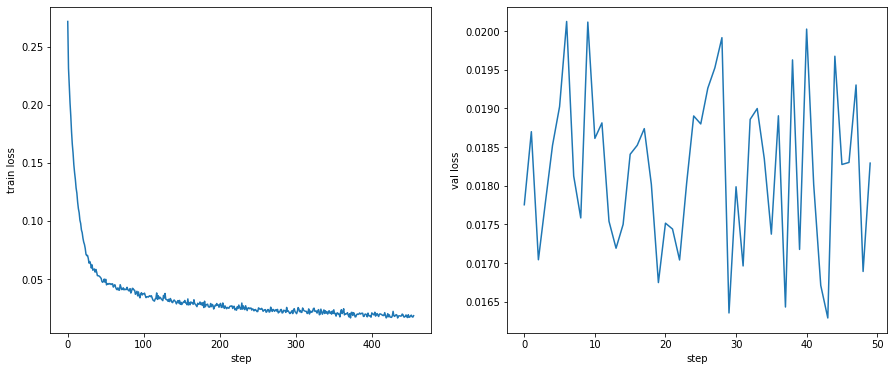

Reconstructed images


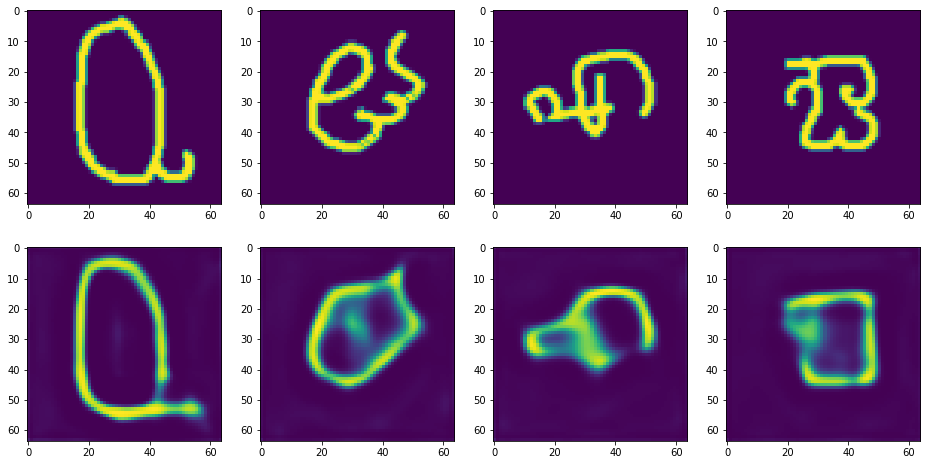

Samples drawn from model


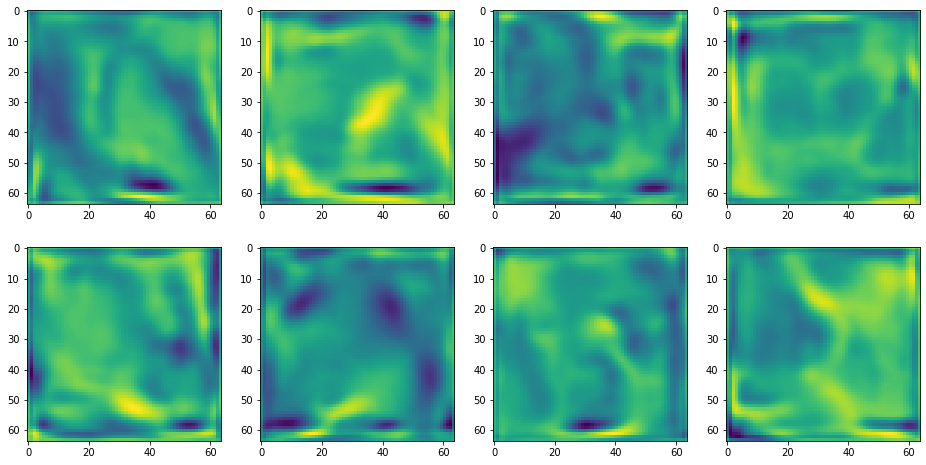

In [10]:
config = dict(
    model=ae,
    optimizer=optim,
    criterion=criterion,
    epochs=1,
    train_dataloader=train_loader,
    val_dataloader=test_loader,
    device=device
)

trainer = Trainer(**callbacks)
trainer.fit(**config);

Поэкспериментируем с различными конфигурациями обучения и архитектурами автоэнкодеров.
Архитектуры с семинаров:

Denoising

In [11]:
from autoencoder import DenoisingAutoEncoder

ae = DenoisingAutoEncoder()
optim = torch.optim.Adam(ae.parameters(), lr=0.001)
criterion = Image2ImageMSELoss()

https://ui.neptune.ai/penchekrak/ysda-spring2021-gans-hw1/e/YSDAGANHW1-14



Losses charts


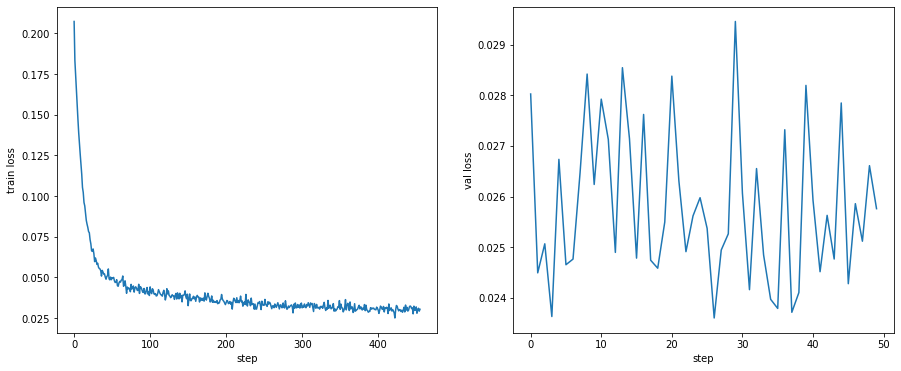

Reconstructed images


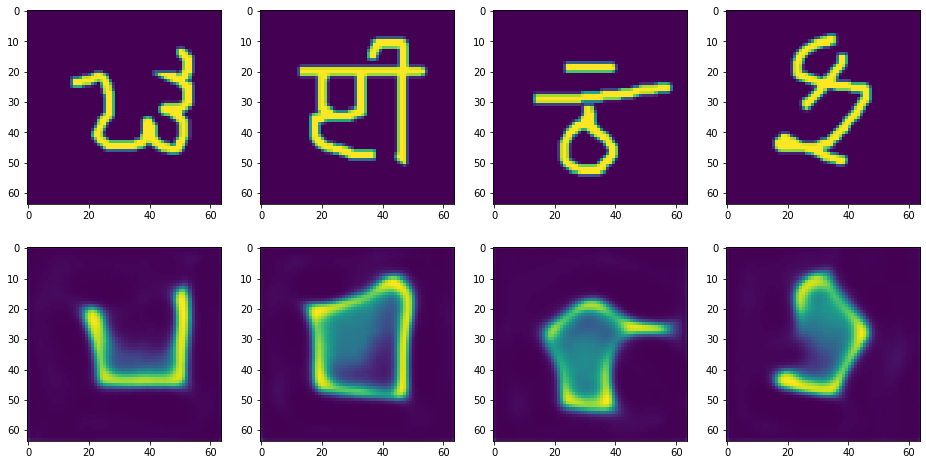

Samples drawn from model


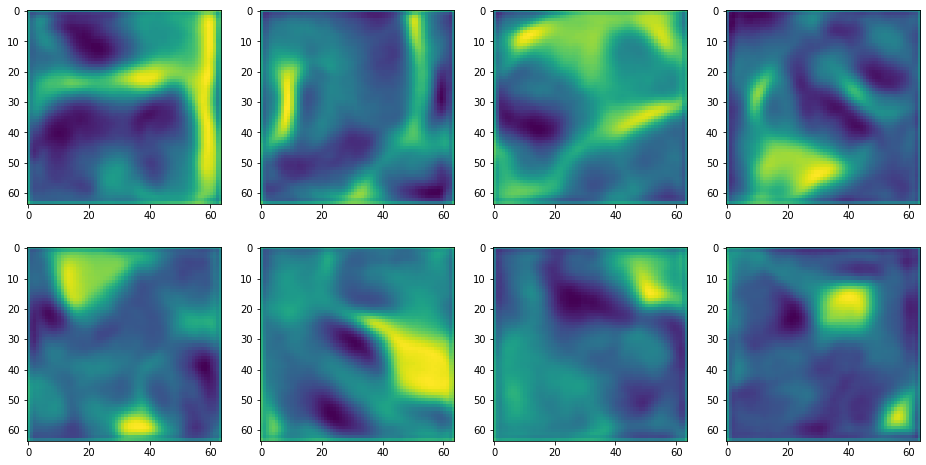

In [12]:
config = dict(
    model=ae,
    optimizer=optim,
    criterion=criterion,
    epochs=1,
    train_dataloader=train_loader,
    val_dataloader=test_loader,
    device=device
)

trainer = Trainer(**callbacks)
trainer.fit(**config);

L1-регуляризованный

In [11]:
from autoencoder import DefaultAutoEncoder

ae = DefaultAutoEncoder()
optim = torch.optim.Adam(ae.parameters(), lr=0.001)
criterion = Image2ImageMixedLossWithLasso(bce_weight=0, mse_weight=1, lasso_weight=0.001)

https://ui.neptune.ai/penchekrak/ysda-spring2021-gans-hw1/e/YSDAGANHW1-22



Losses charts


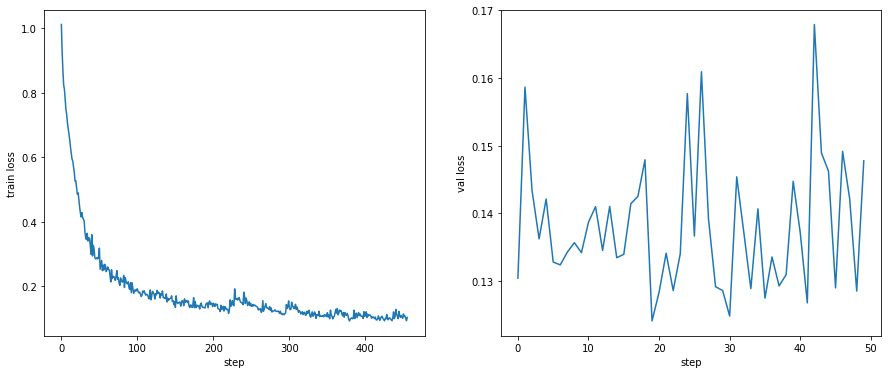

Reconstructed images


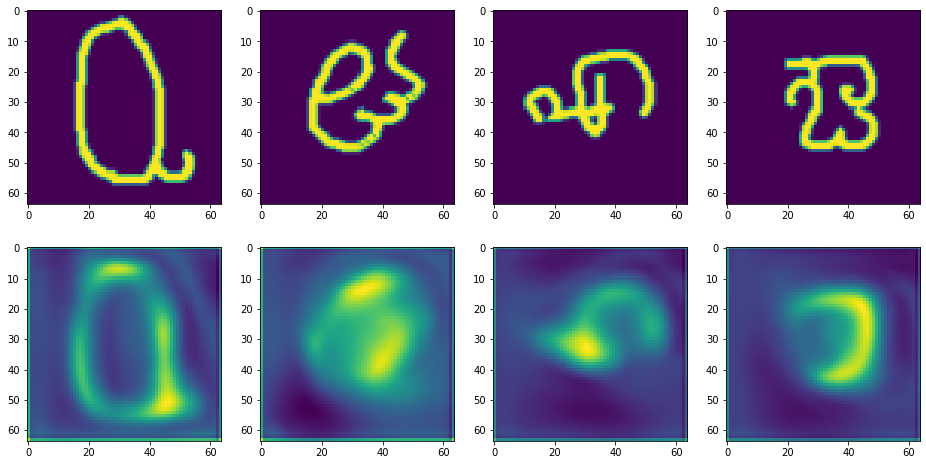

Samples drawn from model


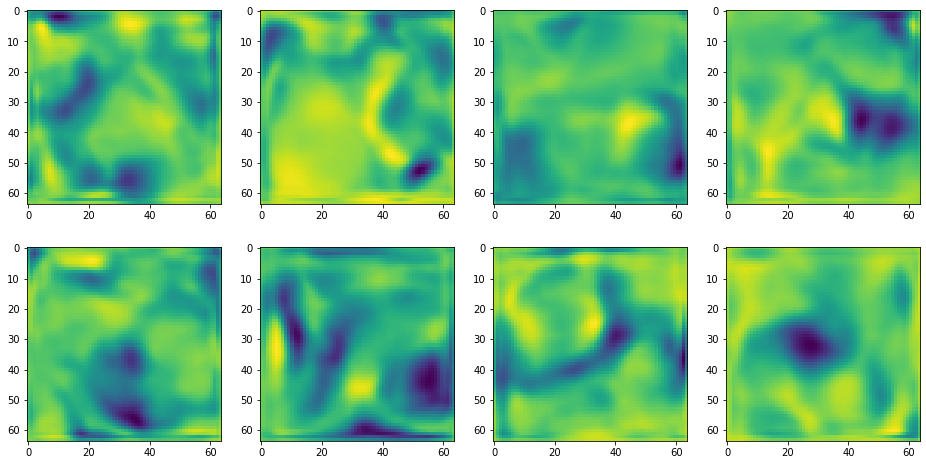

In [12]:
config = dict(
    model=ae,
    optimizer=optim,
    criterion=criterion,
    epochs=1,
    train_dataloader=train_loader,
    val_dataloader=test_loader,
    device=device
)

trainer = Trainer(**callbacks)
trainer.fit(**config);

L1-регуляризованный (с БОЛЬШИМ коэффициентом, для красоты)

In [10]:
from autoencoder import DefaultAutoEncoder

ae = DefaultAutoEncoder()
optim = torch.optim.Adam(ae.parameters(), lr=0.001)
criterion = Image2ImageMixedLossWithLasso(bce_weight=0, mse_weight=1, lasso_weight=0.1)

https://ui.neptune.ai/penchekrak/ysda-spring2021-gans-hw1/e/YSDAGANHW1-26



Losses charts


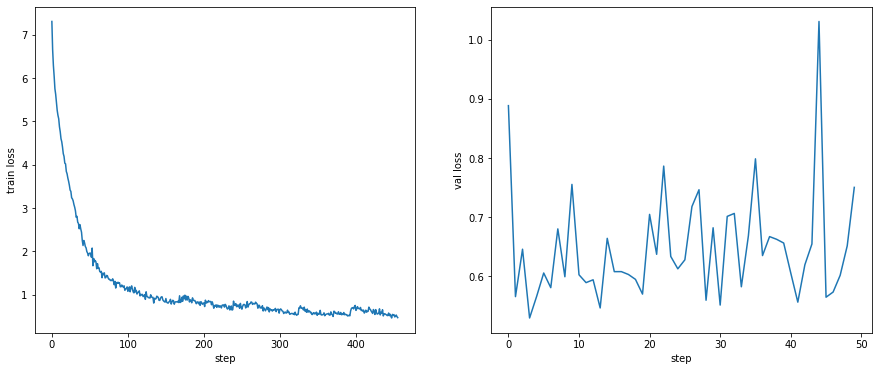

Reconstructed images


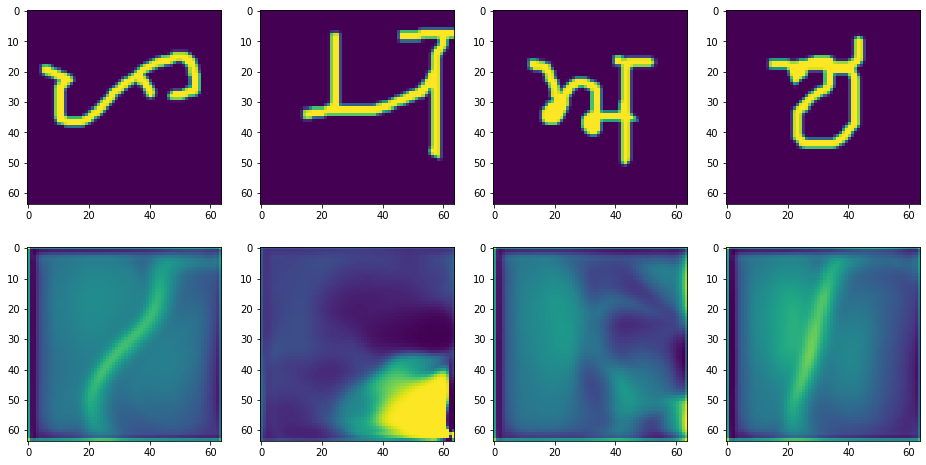

Samples drawn from model


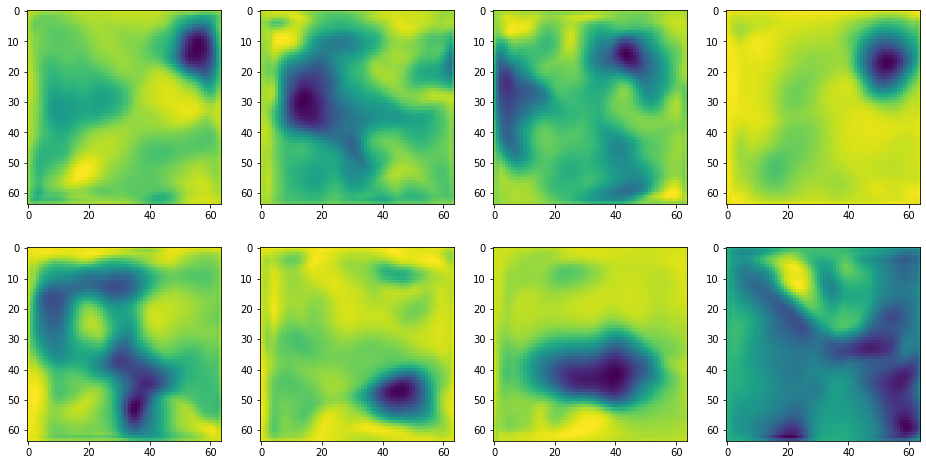

In [11]:
config = dict(
    model=ae,
    optimizer=optim,
    criterion=criterion,
    epochs=1,
    train_dataloader=train_loader,
    val_dataloader=test_loader,
    device=device
)

trainer = Trainer(**callbacks)
trainer.fit(**config);

Кроссэнтропийный лосс и смешанный лосс

In [15]:
from autoencoder import DefaultAutoEncoder

ae = DefaultAutoEncoder()
optim = torch.optim.Adam(ae.parameters(), lr=0.001)
criterion = Image2ImageBCELoss()

https://ui.neptune.ai/penchekrak/ysda-spring2021-gans-hw1/e/YSDAGANHW1-16



Losses charts


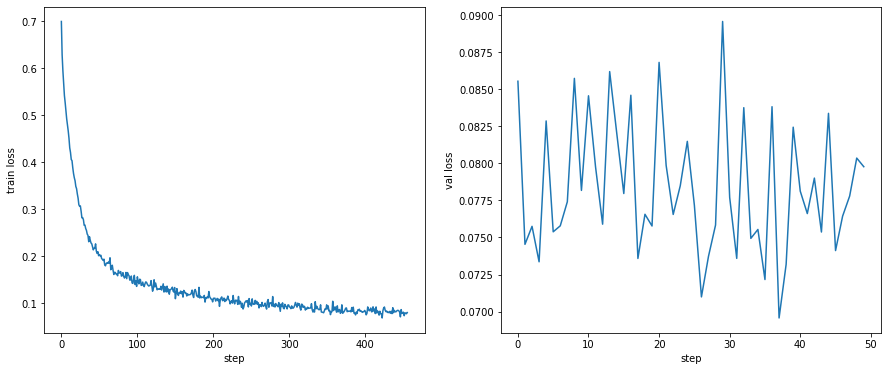

Reconstructed images


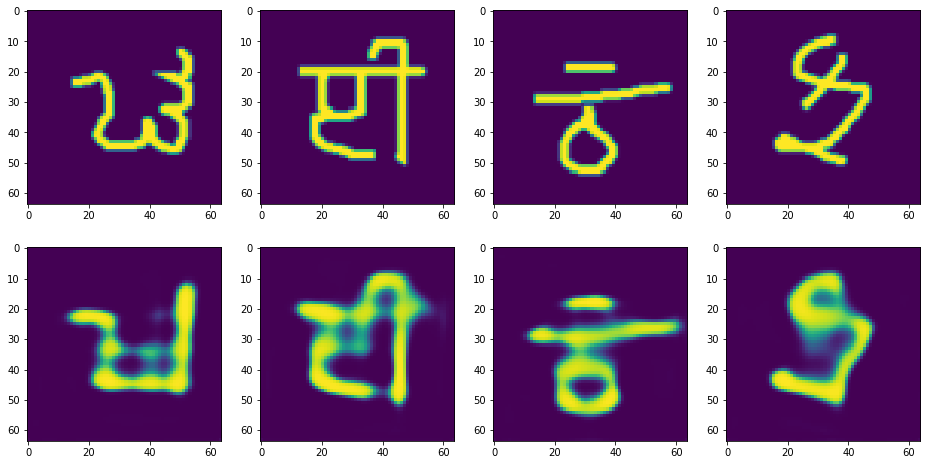

Samples drawn from model


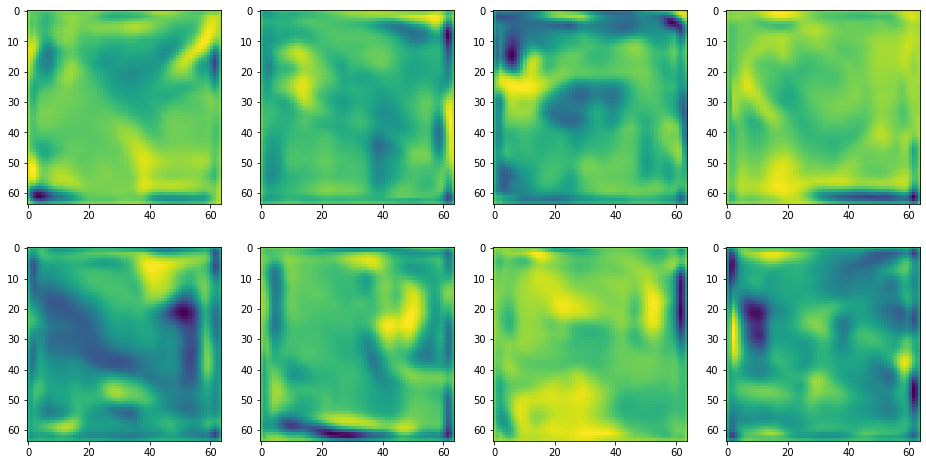

In [16]:
config = dict(
    model=ae,
    optimizer=optim,
    criterion=criterion,
    epochs=1,
    train_dataloader=train_loader,
    val_dataloader=test_loader,
    device=device
)

trainer = Trainer(**callbacks)
trainer.fit(**config);

In [17]:
from autoencoder import DefaultAutoEncoder

ae = DefaultAutoEncoder()
optim = torch.optim.Adam(ae.parameters(), lr=0.001)
criterion = Image2ImageMixedLoss(bce_weight=0.6667, mse_weight=0.3333)

https://ui.neptune.ai/penchekrak/ysda-spring2021-gans-hw1/e/YSDAGANHW1-17



Losses charts


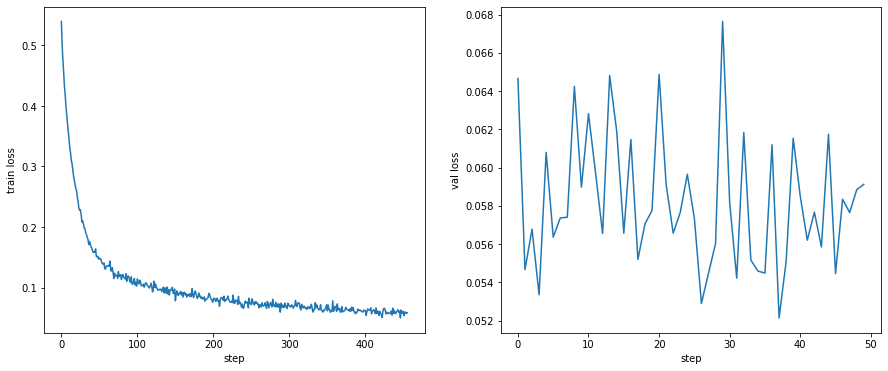

Reconstructed images


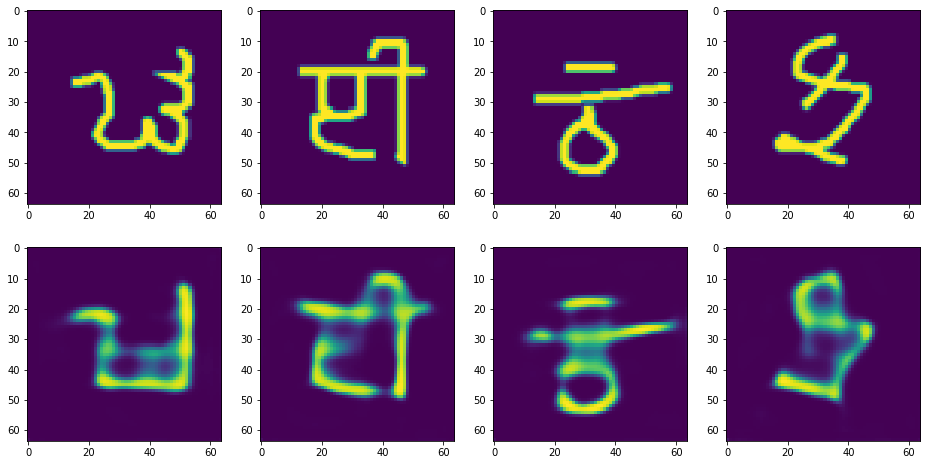

Samples drawn from model


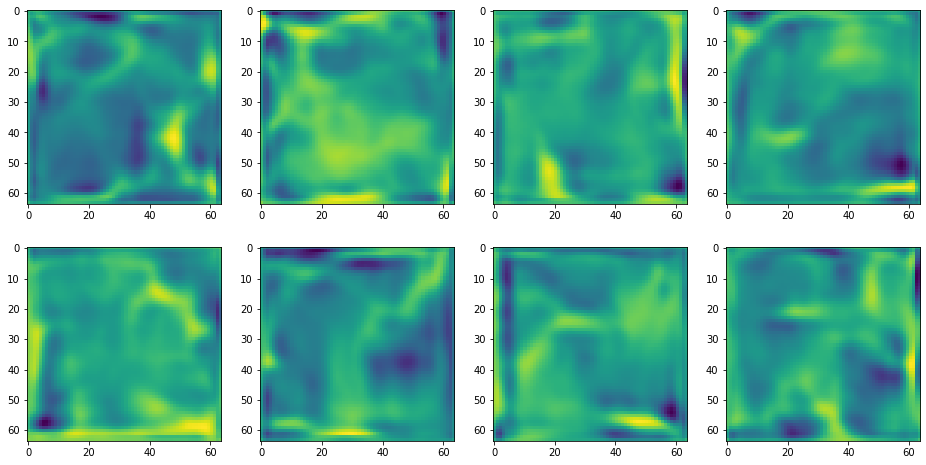

In [18]:
config = dict(
    model=ae,
    optimizer=optim,
    criterion=criterion,
    epochs=1,
    train_dataloader=train_loader,
    val_dataloader=test_loader,
    device=device
)

trainer = Trainer(**callbacks)
trainer.fit(**config);

Несколько эпох и прочие твики

In [16]:
from autoencoder import DefaultAutoEncoder

ae = DefaultAutoEncoder()
optim = torch.optim.Adam(ae.parameters(), lr=0.001)
criterion = Image2ImageMixedLoss(bce_weight=0.5, mse_weight=0.5)

https://ui.neptune.ai/penchekrak/ysda-spring2021-gans-hw1/e/YSDAGANHW1-29



Losses charts


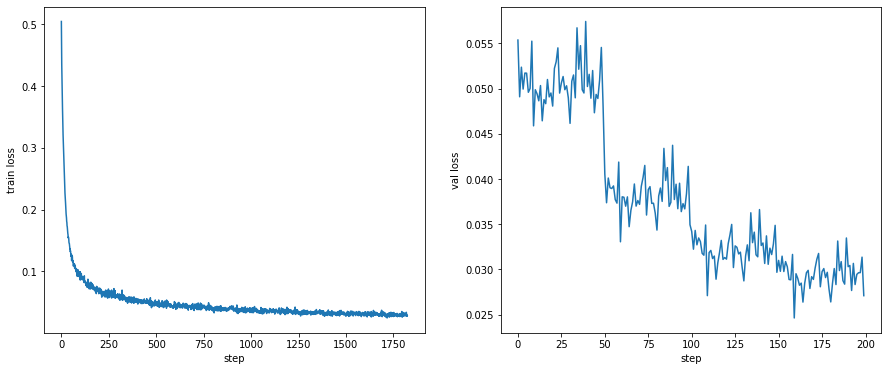

Reconstructed images


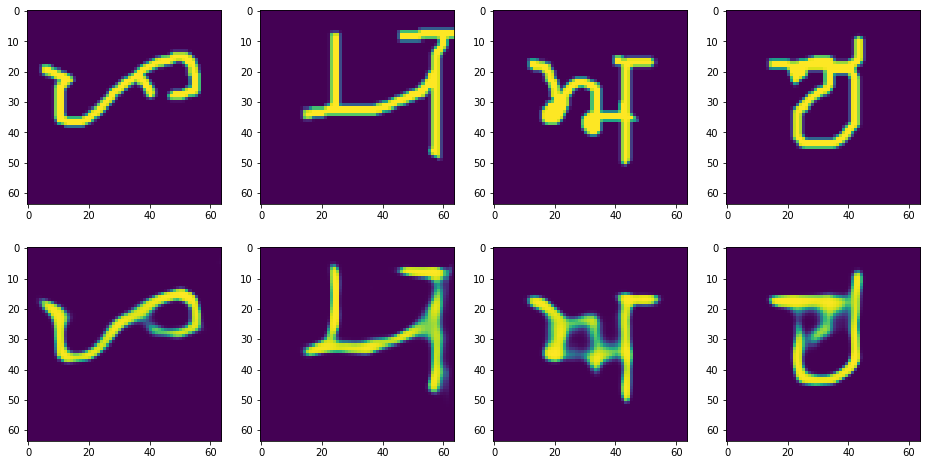

Samples drawn from model


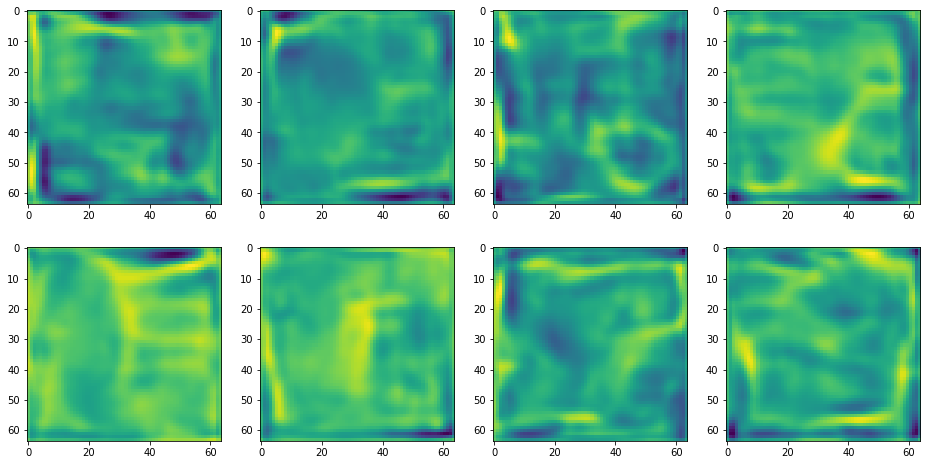

In [17]:
config = dict(
    model=ae,
    optimizer=optim,
    criterion=criterion,
    epochs=4,
    train_dataloader=train_loader,
    val_dataloader=test_loader,
    device=device
)

trainer = Trainer(**callbacks)
trainer.fit(**config);

Другая архитектура

In [47]:
from autoencoder import AdvancedAutoEncoder

ae = AdvancedAutoEncoder()
optim = torch.optim.Adam(ae.parameters(), lr=0.001)
criterion = Image2ImageMixedLoss(bce_weight=0.5, mse_weight=0.5)

https://ui.neptune.ai/penchekrak/ysda-spring2021-gans-hw1/e/YSDAGANHW1-32



Losses charts


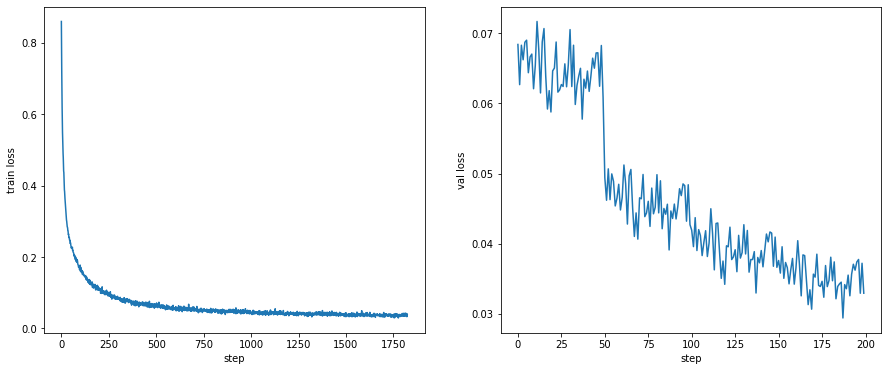

Reconstructed images


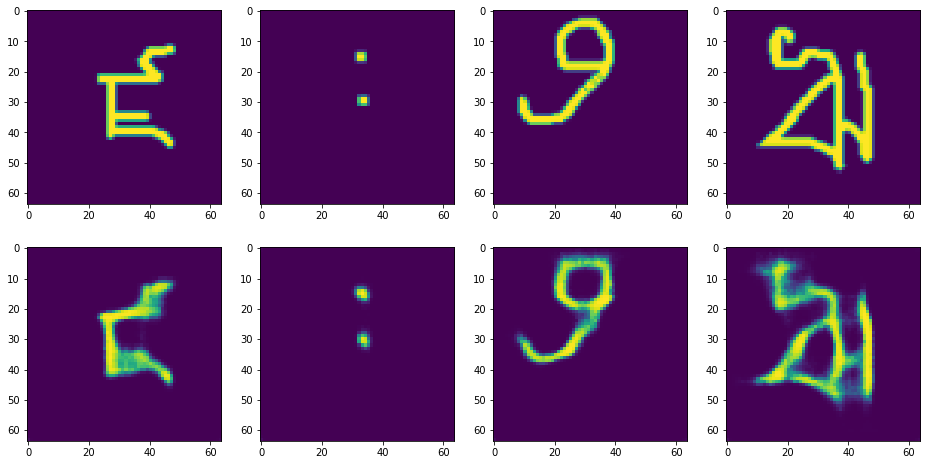

Samples drawn from model


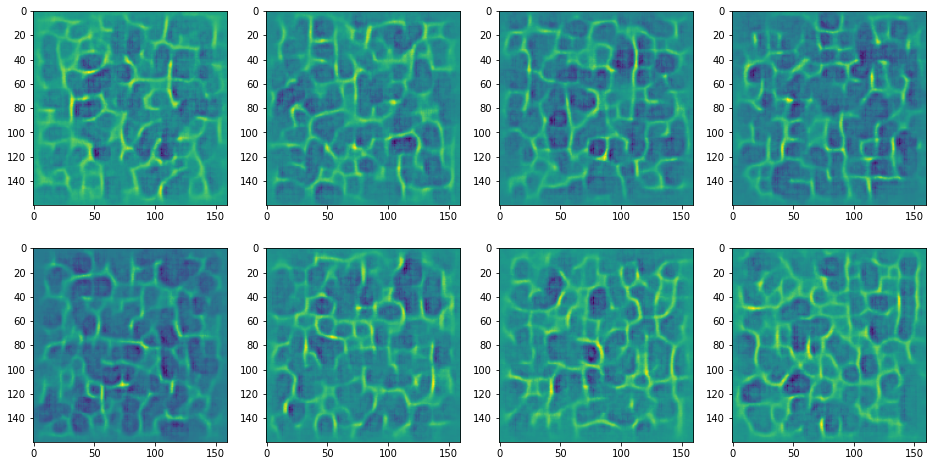

In [48]:
config = dict(
    model=ae,
    optimizer=optim,
    criterion=criterion,
    epochs=4,
    train_dataloader=train_loader,
    val_dataloader=test_loader,
    device=device
)

trainer = Trainer(**callbacks)
trainer.fit(**config);

Мало посмотреть на результаты глазами, надо еще посчитать метрики качества.

Для этой задачи не очень хочется использовать FID с Inception обученными на ImageNet'е, поэтому предлагается обучить свою модель классификации на MNIST

Это можно сделать здесь (только красиво) или вынести в отдельную тетрадку/файлы

### Задача 2 (0.3 балла):

Научить внешний классификатор классифицировать MNIST, использовать его в подсчете FID между реальным Omniglot и выходами автоэнкодера

In [10]:
from torchvision.datasets import MNIST

mnist_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
#     transforms.Normalize([0.5], [0.5])
])

mnist_dataset = MNIST('./MNIST', train=True, transform=mnist_transforms, download=True)
mnist_labels = []
for _, label in mnist_dataset:
    mnist_labels.append(label)
    
# делаем так, чтобы сплит был сбалансированным по классам
indices_train, indices_test, _, _ = train_test_split(list(range(len(mnist_labels))), mnist_labels, test_size=0.01, stratify=mnist_labels)

mnist_train_dataset = Subset(mnist_dataset, indices=indices_train)
mnist_test_dataset = Subset(mnist_dataset, indices=indices_test)

mnist_loader = DataLoader(mnist_train_dataset, batch_size=batch_size, drop_last=True, shuffle=True)
mnist_val_loader = DataLoader(mnist_test_dataset, batch_size=batch_size, drop_last=True)

In [11]:
from classifier import ResNetClassifier
from losses import ClassificationCELoss

mnist_clf = ResNetClassifier(n_classes=10)
mnist_clf_optim = torch.optim.Adam(mnist_clf.parameters(), lr=0.001)
mnist_criterion = ClassificationCELoss()

https://ui.neptune.ai/penchekrak/ysda-spring2021-gans-hw1/e/YSDAGANHW1-30



Losses charts


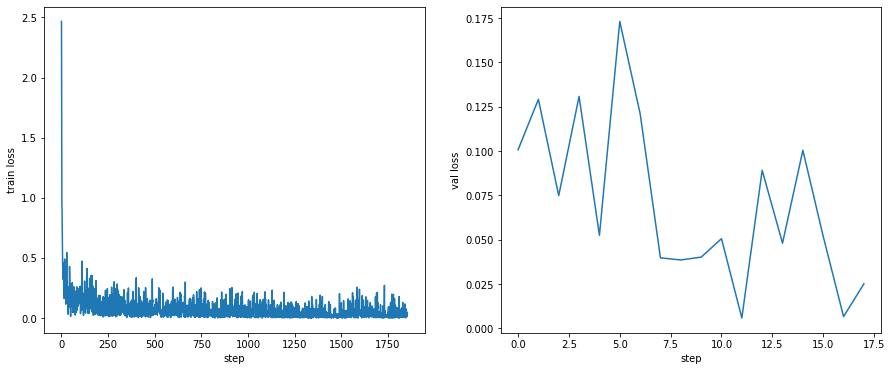

Final accuracy: 0.984375


In [12]:
callbacks = dict(
    on_fit_start=[NeptuneOnFitStart(name='mnist experiment')],
    on_training_batch_end=[NeptuneOnTrainingBatchEnd()],
    on_validation_batch_end=[NeptuneValidationBatchEnd()],
    on_fit_end=[PlotLossesOnFitEnd(), ClfAccuracyOnFitEnd(), NeptuneOnFitEnd()], 
)
config = dict(
    model=mnist_clf,
    optimizer=mnist_clf_optim,
    criterion=mnist_criterion,
    epochs=2,
    train_dataloader=mnist_loader,
    val_dataloader=mnist_val_loader,
    device=device
)

trainer = Trainer(**callbacks)
trainer.fit(**config);

In [27]:
from calculate_fid import calculate_fid

print(f"FID for AE: {calculate_fid(test_loader, ae, mnist_clf)}")

Frechet distance calculation: 100%|██████████| 50/50 [00:04<00:00, 10.76it/s]


FID for AE: 6.863577012366534


In [28]:
class NoiseRecoModel(nn.Module):
    def __init__(self, intensivity=0.1):
        super().__init__()
        # self.placeholder_layer
        # ненужный слой, который позвоняет в calculate_fid смотреть на каком девайсе расположена сетка
        self.placeholder_layer = nn.Linear(1, 1)
        self.intensivity = intensivity
        
    def forward(self, x):
        return x + torch.rand_like(x) * self.intensivity

Проверим насколько наша метрика стабильна: чем больше шум, тем больше она должна становиться

In [30]:
for noise_level in [0.001, 0.01, 0.05, 0.1, 0.5, 0.7, 1.]:
    noise_model = NoiseRecoModel(noise_level).to(device)
    print(f"FID for noise {noise_level}: {calculate_fid(test_loader, noise_model, mnist_clf)}", flush=True)
    

Frechet distance calculation: 100%|██████████| 50/50 [00:02<00:00, 23.78it/s]


FID for noise 0.001: 0.00017048474256853297


Frechet distance calculation: 100%|██████████| 50/50 [00:02<00:00, 23.47it/s]


FID for noise 0.01: 0.016678208063808597


Frechet distance calculation: 100%|██████████| 50/50 [00:02<00:00, 23.48it/s]


FID for noise 0.05: 0.4133308181350799


Frechet distance calculation: 100%|██████████| 50/50 [00:02<00:00, 24.28it/s]


FID for noise 0.1: 1.8141610994360349


Frechet distance calculation: 100%|██████████| 50/50 [00:01<00:00, 26.00it/s]


FID for noise 0.5: 307.872620180103


Frechet distance calculation: 100%|██████████| 50/50 [00:01<00:00, 25.56it/s]


FID for noise 0.7: 833.8430485369938


Frechet distance calculation: 100%|██████████| 50/50 [00:01<00:00, 26.14it/s]


FID for noise 1.0: 2097.2865074520587


Понятно что сам по себе автоэнкодер - такая себе генеративная модель, хоть ее и можно использовать в таком качестве

Мы предлагаем использовать латентные фичи из AE для классификации.

Главная проблема классификации на Omniglot в том, что классов очень много и обычные классификаторы не могут справиться:

### Задача 3 (0.2 балла):

Попробовать честную классификацию на Omniglot, довести ее до приличного качества.

In [24]:
from classifier import ResNetClassifier
from losses import ClassificationCELoss

omniglot_clf = ResNetClassifier(n_classes=1623)
omniglot_clf_optim = torch.optim.Adam(omniglot_clf.parameters(), lr=0.001)
omniglot_criterion = ClassificationCELoss()

https://ui.neptune.ai/penchekrak/ysda-spring2021-gans-hw1/e/YSDAGANHW1-20



Losses charts


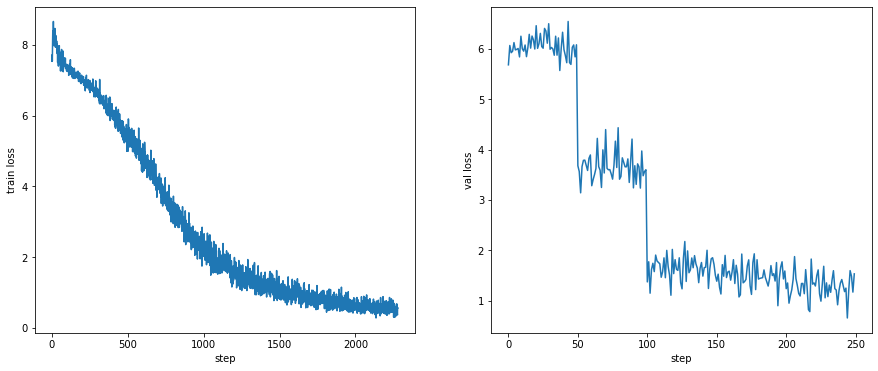

Final accuracy: 0.666875


In [25]:
callbacks = dict(
    on_fit_start=[NeptuneOnFitStart(name='omniglot experiment')],
    on_training_batch_end=[NeptuneOnTrainingBatchEnd()],
    on_validation_batch_end=[NeptuneValidationBatchEnd()],
    on_fit_end=[PlotLossesOnFitEnd(), ClfAccuracyOnFitEnd(), NeptuneOnFitEnd()], 
)
config = dict(
    model=omniglot_clf,
    optimizer=omniglot_clf_optim,
    criterion=omniglot_criterion,
    epochs=5,
    train_dataloader=train_loader,
    val_dataloader=test_loader,
    device=device
)

trainer = Trainer(**callbacks)
trainer.fit(**config);

~~Посчитаем аккураси:~~ Подсчитано сверху

In [35]:
print(f"random accuracy: {1/1623}")
print(f"CNN accuracy: {accuracy_score(true_labels, clf_predict_labels)}")

random accuracy: 0.0006161429451632779
CNN accuracy: 0.1103344298245614


Возможное решение проблемы с классификацией - обработка данный автоэнкодером и использование преобразованных латентных фичей вместо картинок.

Латентные фичи можно представить в виде табличных 1D данных, на которых можно учить даже разные бустинги.


### Задача 4 (0.2 балла):

Получить латентные представления от картинок в Omniglot, выучить любую (хорошую) модель классификации на них до адекватного качества.

note: не забывайте учить на трейне, а считать аккураси на тесте

In [14]:
from autoencoder import DefaultAutoEncoder

In [16]:
ae = DefaultAutoEncoder()
ae.load_state_dict(torch.load('last_model.ckpt'))

<All keys matched successfully>

In [49]:
features = []
labels = []
ae.to(device)
with torch.no_grad():
    for image, label in train_loader:
        features.append(ae.get_latent_features(image.to(device)))
        labels.append(label)
features_ = torch.cat(features, dim=0).detach().cpu().numpy()
labels_ = torch.cat(labels, dim=0).detach().cpu().numpy()

In [51]:
test_features = []
true_labels = []
ae.to(device)
with torch.no_grad():
    for image, label in test_loader:
        test_features.append(ae.get_latent_features(image.to(device)))
        true_labels.append(label)
true_labels_ = torch.cat(true_labels, dim=0).detach().cpu().numpy()
test_features_ = torch.cat(test_features, dim=0).detach().cpu().numpy()

In [18]:
import xgboost
xgb = xgboost.XGBClassifier(n_estimators=100, n_jobs=20)

In [ ]:
xgb.fit(features_, labels_)

In [ ]:
predictions = xgb.predict(test_features_)

In [32]:
from sklearn.metrics import accuracy_score
print(f"xgboost + AE accuracy: {accuracy_score(true_labels_, predictions)}")

xgboost + AE accuracy: 0.301563840235197


In [52]:
from sklearn.ensemble import RandomForestClassifier

In [60]:
rf = RandomForestClassifier(n_estimators=1000, n_jobs=20, max_samples=0.3, max_depth=7)

In [61]:
rf.fit(features_, labels_)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7, max_features='auto',
                       max_leaf_nodes=None, max_samples=0.3,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=20, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [62]:
predictions = rf.predict(test_features_)

In [63]:
from sklearn.metrics import accuracy_score
print(f"random forest + AE accuracy: {accuracy_score(true_labels_, predictions)}")

random forest + AE accuracy: 0.0715625


In [46]:
pred = clf.predict(latent_test)

print(f"random accuracy: {1/1623}")
print(f"xgboost + AE accuracy: {accuracy_score(true_labels, pred)}")

random accuracy: 0.0006161429451632779
xgboost + AE accuracy: 0.7185032894736842
